In [1]:
import numpy as np
from scipy.optimize import curve_fit
from utils import sample_observed_data_berkson, sample_observed_data_classical
from tqdm import tqdm

In [2]:
confidence_level = 0.90
num_realizations = 1
seed = 112
#folder_path = '/dcs/pg23/u1604520/mem/results/poly_berkson_unifstart/'
folder_path = '/dcs/pg23/u1604520/mem/results/exponential_berkson_unifstart/'

In [3]:
scales_nu = [0.000001, 0.5,  1.0, 2.0] 
num_scales = len(scales_nu)
c = 1
n = 200
B = 500
theta_star = np.array([1,2]) 
loc_x = 0
scale_x = 1
scale_eps = 0.5
num_methods = 2

In [4]:
def reg_func(theta,x):
    return (np.exp(theta[0] + theta[1]*x))/(1 + np.exp(theta[0] + theta[1]*x))

# def reg_func(theta,x):
#     return theta[0] + theta[1]*x + theta[2]*x**2

In [5]:
def nonlinear_model(x, a, b):
    return (np.exp(a + b*x))/(1 + np.exp(a + b*x)) #a + b*x + c*x**2

# def nonlinear_model(x, a, b, c):
#     return a + b*x + c*x**2 

In [7]:
mses = np.zeros((num_scales, num_realizations, num_methods, len(theta_star)))
stds = np.zeros((num_scales, num_realizations, num_methods, len(theta_star)))
counts = np.zeros((num_scales, len(theta_star)))
coverage_probabilities = np.zeros((num_scales, len(theta_star)))
for j, scale_nu in enumerate(scales_nu):
    seed1 = 12
    seed2 = 112
    seed = 12
    for r in range(num_realizations):
        seed2 += 1
        seed1 += 1
        seed += 1
        boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed1{seed1}_seed2{seed2}.txt')
        data, x = sample_observed_data_berkson(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed1)#np.loadtxt(folder_path+f'data_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        mean_boot_sample = boot_sample.mean(axis=0)
        #mean_simex_sample = simex_sample.mean(axis=0)
        # initial_guess = np.random.uniform(low=-1, high=4, size=(3,)) #[0, 4]  # Initial parameter guess
        # ls_estimator, _ = curve_fit(nonlinear_model, data[:,0], data[:,1], p0=initial_guess)
        #mmd_est = np.loadtxt(folder_path+f'mmd_est_scale_nu{scale_nu}_c{100}_n{n}_B{B}_seed1{seed1}_seed2{seed2}.txt')
        mmd_est = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{0.00000000001}_n{n}_B{B}_seed1{seed1}_seed2{seed2}.txt').mean(axis=0)
        mses[j, r, 0, :] = np.asarray((mean_boot_sample - theta_star)**2)
        mses[j, r, 1, :] = np.asarray((mmd_est - theta_star)**2)

        # Credible interval 
        for i in range(len(theta_star)):
            count = 0
            lower_bound = np.percentile(boot_sample[:, i], (1 - confidence_level) / 2 * 100)
            upper_bound = np.percentile(boot_sample[:, i], (1 + confidence_level) / 2 * 100)
            if lower_bound <= theta_star[i] <= upper_bound:
                count += 1
            counts[j, i] += count
            
    # Calculate the coverage probability
    coverage_probabilities[j, :] = counts[j, :] / num_realizations
    mses_over_runs = np.mean(mses, axis=1)
    stds_mses_over_runs = np.std(mses, axis=1)
        
    print(f"Coverage Probability for theta_1 for ME std {scale_nu}: {coverage_probabilities[j, 0] * 100}%")
    print(f"Coverage Probability for theta_2 for ME std {scale_nu}: {coverage_probabilities[j, 1] * 100}%")
    #print(f"Coverage Probability for theta_3 for ME std {scale_nu}: {coverage_probabilities[2] * 100}%")
    print(f"Mean Squared error for Robust-MEM: {mses_over_runs[j, 0, :]}")
    print(f"Mean Squared error for MMD: {mses_over_runs[j, 1, :]}")
    print(f"Std - Mean Squared error for Robust-MEM: {stds_mses_over_runs[j, 0, :]}")
    print(f"Std - Mean Squared error for MMD: {stds_mses_over_runs[j, 1, :]}")

Coverage Probability for theta_1 for ME std 1e-06: 0.0%
Coverage Probability for theta_2 for ME std 1e-06: 100.0%
Mean Squared error for Robust-MEM: [0.06653868 0.01178276]
Mean Squared error for MMD: [0.02500745 0.04353702]
Std - Mean Squared error for Robust-MEM: [0. 0.]
Std - Mean Squared error for MMD: [0. 0.]
Coverage Probability for theta_1 for ME std 0.5: 100.0%
Coverage Probability for theta_2 for ME std 0.5: 0.0%
Mean Squared error for Robust-MEM: [1.00005423e-05 2.96970368e-01]
Mean Squared error for MMD: [0.01002431 0.08321914]
Std - Mean Squared error for Robust-MEM: [0. 0.]
Std - Mean Squared error for MMD: [0. 0.]
Coverage Probability for theta_1 for ME std 1.0: 0.0%
Coverage Probability for theta_2 for ME std 1.0: 0.0%
Mean Squared error for Robust-MEM: [0.06810745 1.46051243]
Mean Squared error for MMD: [0.08289791 0.58697516]
Std - Mean Squared error for Robust-MEM: [0. 0.]
Std - Mean Squared error for MMD: [0. 0.]
Coverage Probability for theta_1 for ME std 2.0: 0.0%


### Make a table

In [20]:
import pandas as pd

Coverage probabilities for Robust MEM

In [21]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    data_coverage = {'Param': ['$\theta_1$', '$\theta_2$'], 'Coverage prob.': coverage_probabilities[i, :], '$\sigma_\nu$': scale_nu}
    df = pd.DataFrame(data_coverage)
    dfs.append(df)
cov_df = pd.concat(dfs, ignore_index=True)
cov_gb = cov_df.groupby((['Param', '$\sigma_\nu$'])).mean()
pivot_cov = cov_gb.pivot_table(index=['Param'], columns='$\sigma_\nu$', values=['Coverage prob.'])
pivot_cov

Coverage prob.                           
$\sigma_
u$       0.000001 0.500000 1.000000 2.000000
Param                                                
$\theta_1$             1.0      1.0      0.0      0.0
$\theta_2$             1.0      0.0      0.0      0.0

MSE and STD

In [22]:
def create_dataframe(mse_array, std_array, scale_nu, method_name):
    
    data = {'Param': ['$\theta_1$', '$\theta_2$'], 'MSE': mse_array, 'Std': std_array, '$\sigma_\nu$': scale_nu, 'Method': [method_name]*len(mse_array)}
    df = pd.DataFrame(data)
    
    return df

In [23]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,0,:], stds_mses_over_runs[i,0,:], scale_nu, 'Robust-MEM (MMD)')
    dfs.append(df)
robustmem_df = pd.concat(dfs, ignore_index=True)

In [24]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,1,:], stds_mses_over_runs[i,1,:], scale_nu, 'MMD')
    dfs.append(df)
ls_df = pd.concat(dfs, ignore_index=True)

In [25]:
df_all = pd.concat([robustmem_df, ls_df])

In [26]:
df_all

,Param,MSE,Std,$\sigma_\nu$,Method
0,$\theta_1$,0.025007,0.0,0.000001,Robust-MEM (MMD)
1,$\theta_2$,0.043537,0.0,0.000001,Robust-MEM (MMD)
2,$\theta_1$,0.010024,0.0,0.500000,Robust-MEM (MMD)
3,$\theta_2$,0.083219,0.0,0.500000,Robust-MEM (MMD)
4,$\theta_1$,0.082898,0.0,1.000000,Robust-MEM (MMD)
5,$\theta_2$,0.586975,0.0,1.000000,Robust-MEM (MMD)
6,$\theta_1$,0.231754,0.0,2.000000,Robust-MEM (MMD)
7,$\theta_2$,1.900445,0.0,2.000000,Robust-MEM (MMD)
0,$\theta_1$,0.145504,0.0,0.000001,MMD
1,$\theta_2$,1.280983,0.0,0.000001,MMD


In [27]:
gb = df_all.groupby(['Method', 'Param', '$\sigma_\nu$']).mean()

In [28]:
pivot_df = gb.pivot_table(index=['Method', 'Param'], columns='$\sigma_\nu$', values=['MSE','Std'])

# Flatten the MultiIndex columns
pivot_df.columns = [f'{col[0]}-{col[1]}' for col in pivot_df.columns]

cols = pivot_df.columns.tolist()
mse_cols = [col for col in cols if 'MSE' in col]
std_cols = [col for col in cols if 'Std' in col]
rearranged_cols = [item for pair in zip(mse_cols, std_cols) for item in pair]
pivot_df = pivot_df[rearranged_cols]

# Reset index to make 'method' and 'param' regular columns
pivot_df.reset_index(inplace=True)
pivot_df

,Method,Param,MSE-1e-06,Std-1e-06,MSE-0.5,Std-0.5,MSE-1.0,Std-1.0,MSE-2.0,Std-2.0
0,MMD,$\theta_1$,0.145504,0.0,0.019875,0.0,0.002044,0.0,0.055996,0.0
1,MMD,$\theta_2$,1.280983,0.0,0.391576,0.0,0.362985,0.0,0.018990,0.0
2,Robust-MEM (MMD),$\theta_1$,0.025007,0.0,0.010024,0.0,0.082898,0.0,0.231754,0.0
3,Robust-MEM (MMD),$\theta_2$,0.043537,0.0,0.083219,0.0,0.586975,0.0,1.900445,0.0


In [16]:
pivot_df = pivot_df.groupby(['Method', 'Param']).mean()
pivot_df

MSE-1e-06  Std-1e-06   MSE-0.5  Std-0.5  \
Method           Param                                                 
MMD              $\theta_1$   0.041873        0.0  0.130670      0.0   
                 $\theta_2$   0.069697        0.0  0.272714      0.0   
Robust-MEM (MMD) $\theta_1$   0.045142        0.0  0.132149      0.0   
                 $\theta_2$   0.060868        0.0  0.760869      0.0   

                              MSE-1.0  Std-1.0   MSE-2.0  Std-2.0  
Method           Param                                             
MMD              $\theta_1$  0.260106      0.0  0.391735      0.0  
                 $\theta_2$  0.817220      0.0  1.648063      0.0  
Robust-MEM (MMD) $\theta_1$  0.281477      0.0  0.486308      0.0  
                 $\theta_2$  2.142644      0.0  3.421140      0.0

In [17]:
new_df = pivot_df.copy(deep=True)
nus = [1e-06, 0.5] #, 0.5, 1.0, 2.0]
# Iterate over columns
for i, nu in enumerate(nus):  # Assuming you have two pairs a_i and b_i
    # Extract corresponding pairs
    a_col = f'MSE-{nu}'
    b_col = f'Std-{nu}'
    # Concatenate values for the title
    new_df[f'$\sigma_\nu = {nu}$'] = pivot_df[a_col].round(3).astype(str) + ' ' + '(' + pivot_df[b_col].round(3).astype(str) + ')'
    new_df = new_df.drop(a_col, axis=1)
    new_df = new_df.drop(b_col, axis=1) 
    

new_df

MSE-1.0  Std-1.0   MSE-2.0  Std-2.0  \
Method           Param                                              
MMD              $\theta_1$  0.260106      0.0  0.391735      0.0   
                 $\theta_2$  0.817220      0.0  1.648063      0.0   
Robust-MEM (MMD) $\theta_1$  0.281477      0.0  0.486308      0.0   
                 $\theta_2$  2.142644      0.0  3.421140      0.0   

                            $\sigma_\nu = 1e-06$ $\sigma_\nu = 0.5$  
Method           Param                                               
MMD              $\theta_1$          0.042 (0.0)        0.131 (0.0)  
                 $\theta_2$           0.07 (0.0)        0.273 (0.0)  
Robust-MEM (MMD) $\theta_1$          0.045 (0.0)        0.132 (0.0)  
                 $\theta_2$          0.061 (0.0)        0.761 (0.0)

In [18]:
latex_table =new_df.to_latex()
print(latex_table)

\begin{tabular}{llrrrrll}
\toprule
 &  & MSE-1.0 & Std-1.0 & MSE-2.0 & Std-2.0 & $\sigma_
u = 1e-06$ & $\sigma_
u = 0.5$ \\
Method & Param &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{MMD} & $	heta_1$ & 0.260106 & 0.000000 & 0.391735 & 0.000000 & 0.042 (0.0) & 0.131 (0.0) \\
 & $	heta_2$ & 0.817220 & 0.000000 & 1.648063 & 0.000000 & 0.07 (0.0) & 0.273 (0.0) \\
\cline{1-8}
\multirow[t]{2}{*}{Robust-MEM (MMD)} & $	heta_1$ & 0.281477 & 0.000000 & 0.486308 & 0.000000 & 0.045 (0.0) & 0.132 (0.0) \\
 & $	heta_2$ & 2.142644 & 0.000000 & 3.421140 & 0.000000 & 0.061 (0.0) & 0.761 (0.0) \\
\cline{1-8}
\bottomrule
\end{tabular}



Plot

In [19]:
def lighten_color(color, amount=0.5):
    """
    From: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [20]:
pip install seaborn

/dcs/pg23/u1604520/.conda/envs/mem-env/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


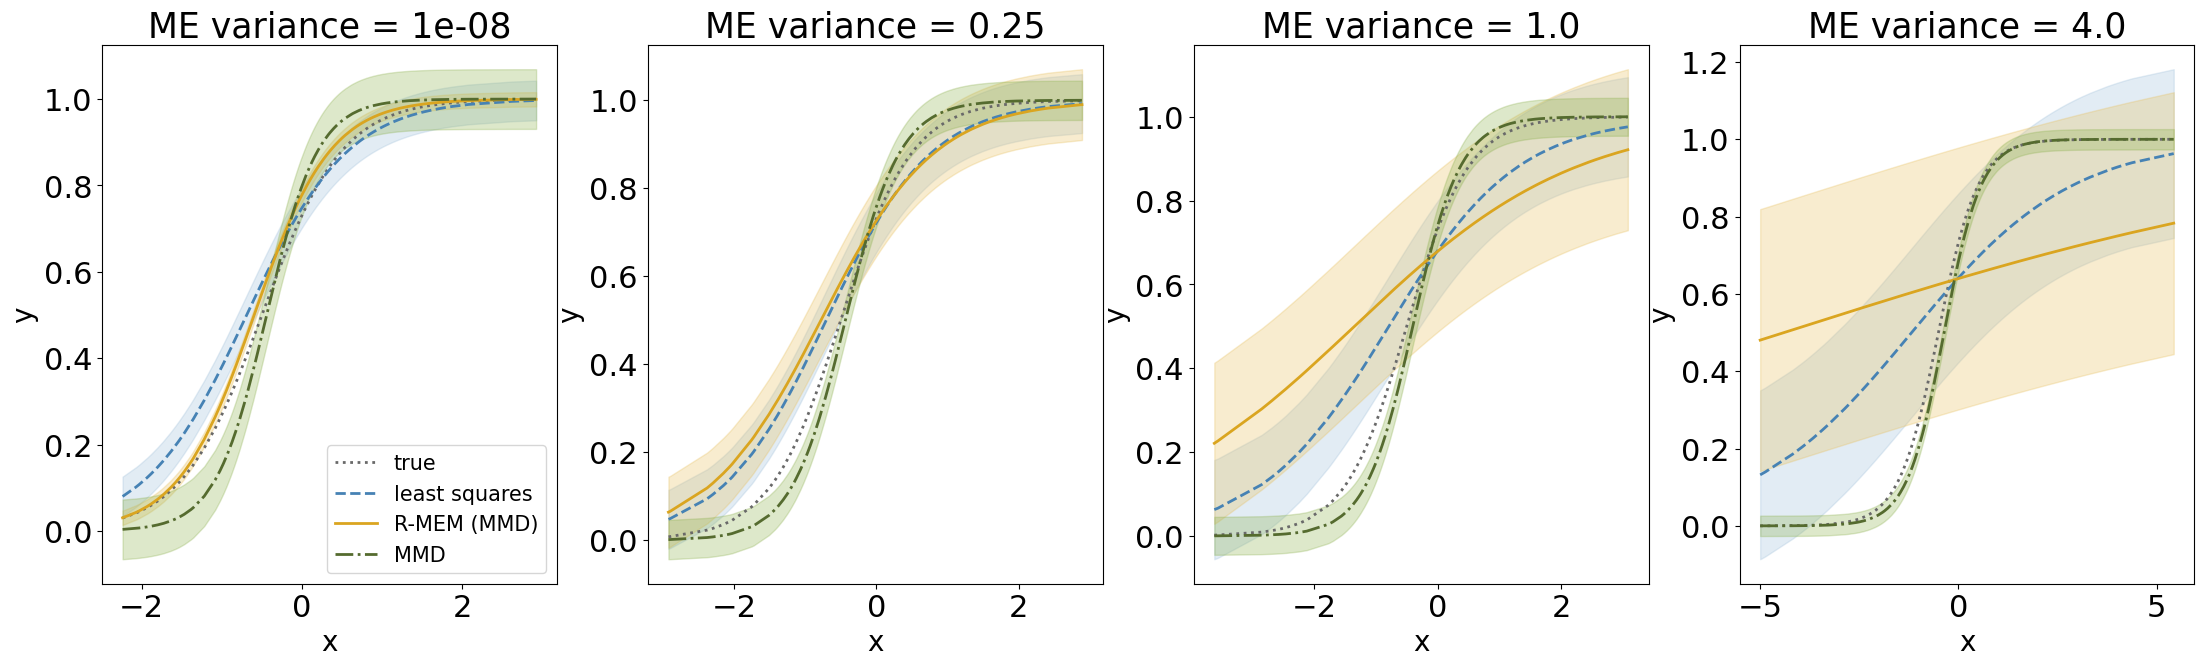

In [21]:
import matplotlib.pyplot as plt
num_methods = 3
num_realizations = 1
num_scales = len(scales_nu)
fig, ax_array = plt.subplots(1, num_scales, figsize=(27,7))
credible_interval = 0.90
n = 200
regs = np.zeros((num_realizations, num_methods, n))
lower_bounds = np.zeros((num_methods, n))
upper_bounds = np.zeros((num_methods, n))
std_error = np.zeros(num_methods)
means = np.zeros((num_methods, n))
for ax, j in zip(ax_array.flatten(), range(0, num_scales)):
    scale_nu = scales_nu[j]
    seed1 = 12
    seed2 = 112
    thetas_over_run = np.zeros((len(theta_star), num_methods, num_realizations))
    for r in range(num_realizations):
        seed1 += 1
        seed2 += 1
        boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed1{seed1}_seed2{seed2}.txt')
        
        data, xis_star = sample_observed_data_berkson(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed1)#np.loadtxt(folder_path+f'data_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        mean_boot_sample = boot_sample.mean(axis=0)
        mmd_est = np.loadtxt(folder_path+f'mmd_est_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed1{seed1}_seed2{seed2}.txt')
        initial_guess = np.random.uniform(low=-1, high=4, size=(2,)) #[0, 4]  # Initial parameter guess
        ls_estimator, _ = curve_fit(nonlinear_model, data[:,0], data[:,1], p0=initial_guess)
        thetas_over_run[:, 0, r] = mean_boot_sample
        thetas_over_run[:, 1, r] = ls_estimator
        thetas_over_run[:, 2, r] = mmd_est
        # xis_star_sorted = np.sort(xis_star)
        # regs[r,0,:] = reg_func(thetas_over_run[:,0,r], xis_star_sorted)
        # regs[r,1,:] = reg_func(thetas_over_run[:,1,r], xis_star_sorted)
        # regs[r,2,:] = reg_func(thetas_over_run[:,2,r], xis_star_sorted)
        
    # test data
    data, xis_star = sample_observed_data_berkson(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, 300)
    xis_star_sorted = np.sort(xis_star)
    Y_real = reg_func(theta_star, xis_star_sorted)
    means[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1), xis_star_sorted)
    residuals = np.array(Y_real) - means[0, :]
    std_error[0] = np.std(residuals, axis=0)
    lower_bounds[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1) - thetas_over_run[:,0,:].std(axis=1), xis_star_sorted)
    upper_bounds[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1) + thetas_over_run[:,0,:].std(axis=1), xis_star_sorted)

    means[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1), xis_star_sorted)
    residuals = np.array(Y_real) - means[1, :]
    std_error[1] = np.std(residuals, axis=0)
    lower_bounds[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1) - thetas_over_run[:,1,:].std(axis=1), xis_star_sorted)
    upper_bounds[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1) + thetas_over_run[:,1,:].std(axis=1), xis_star_sorted)
    
    means[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1), xis_star_sorted)
    residuals = np.array(Y_real) - means[2, :]
    std_error[2] = np.std(residuals, axis=0)
    lower_bounds[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1) - thetas_over_run[:,2,:].std(axis=1), xis_star_sorted)
    upper_bounds[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1) + thetas_over_run[:,2,:].std(axis=1), xis_star_sorted)
    
    ax.plot(xis_star_sorted, Y_real, linestyle='dotted', label='true', color='dimgrey', lw=2)
    
    ax.plot(xis_star_sorted, means[1,:], linestyle='dashed', label='least squares', color='#4682B4', lw=2)
    #ax.fill_between(xis_star_sorted, lower_bounds[2, :], upper_bounds[2, :], color=lighten_color('#4682B4'), alpha=0.3)
    ax.fill_between(xis_star_sorted, means[1, :] - std_error[1], means[1, :] + std_error[1], color=lighten_color('#4682B4'), alpha=0.3)
    
    ax.plot(xis_star_sorted, means[0, :], linestyle='solid', label='R-MEM (MMD)', color='goldenrod',lw=2)
    #ax.fill_between(xis_star_sorted, lower_bounds[0, :], upper_bounds[0, :], color=lighten_color('goldenrod', 0.7), alpha=0.3)
    ax.fill_between(xis_star_sorted, means[0, :] - std_error[0], means[0, :] + std_error[0], color=lighten_color('goldenrod', 0.7), alpha=0.3)
    
    ax.plot(xis_star_sorted, means[2, :], linestyle='dashdot', label='MMD', color='#556B2F',lw=2)
    ax.fill_between(xis_star_sorted, means[2, :] - std_error[2], means[2, :] + std_error[2], color=lighten_color('#556B2F', 0.7), alpha=0.3)

    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    ax.patch.set_facecolor('white')
    if j == 0:
        ax.set_title(f'ME variance = 1e-08', fontsize=25)
    elif j == 1 or j == 3:
        ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)
    elif j == 2:
        ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)

    ax.set_xlabel('x',fontsize=20)
    ax.set_ylabel('y',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)
    if j == 0:
        ax.legend(fontsize=15)

### Palia

TypeError: nonlinear_model() takes 3 positional arguments but 4 were given

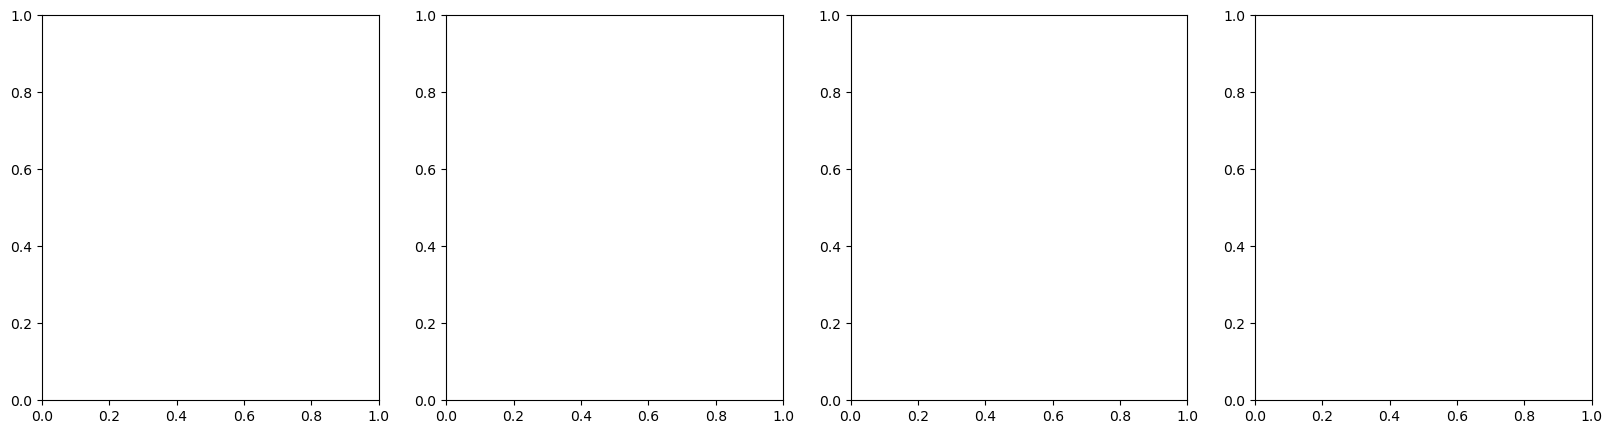

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

num_thetas = 2
scales_nu = [0.000001, 0.5,  1.0, 2.0] 
num_scales = len(scales_nu)
c = 100
n = 200
B = 500
theta_star = np.array([1,2,3]) 
loc_x = 0
scale_x = 1
scale_eps = 0.5
num_methods = 3
fig, ax_array = plt.subplots(1, num_scales, figsize=(20,5))
seed = 13

for ax, i in zip(ax_array.flatten(), range(0, num_scales)):
  scale_nu = scales_nu[i]
  boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed1{seed}_seed21{seed}.txt')
  thetas = np.mean(boot_sample, axis=0).flatten()
  
  data, xis_star = sample_observed_data_berkson(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed)
  initial_guess = [0,0,0] #[0, 4]  # Initial parameter guess
  ls_estimator, _ = curve_fit(nonlinear_model, data[:,0], data[:,1], p0=initial_guess)
  
  mmd_est = np.loadtxt(folder_path+f'mmd_est_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed1{seed1}_seed2{seed2}.txt')
  
  # # Credible intervals
  # credible_interval = 0.90
  # regs = np.zeros((B,len(xis_star)))
  # for b in range(B):
  #   regs[b,:] = reg_func(thetas_all[b,:], xis_star)
  # lower_bound = np.percentile(regs, (1 - credible_interval) / 2 * 100, axis=1)
  # upper_bound = np.percentile(regs, (1 + credible_interval) / 2 * 100, axis=1)
  
  xis_star = np.sort(xis_star)
  Y = reg_func(thetas, xis_star)
  Y_real = reg_func(theta_star, xis_star)
  Y_ls = reg_func(ls_estimator, xis_star)
  Y_mmd = reg_func(mmd_est, xis_star)

  ax.scatter(data[:,0],data[:,1], marker="x", label='observed data', color='cadetblue', alpha=0.4)
  ax.scatter(xis_star, data[:,1], marker = "o", label='real data', color=lighten_color('indianred',amount=0.8), alpha=0.4)

  ax.plot(xis_star, Y_real, label='true', color='dimgrey', lw=3)
  ax.plot(xis_star, Y_ls, label='least squares', color='#4682B4', lw=3)
  ax.plot(xis_star, Y, label='R-MEM (MMD)', color='goldenrod',lw=3)
  ax.plot(xis_star, Y_mmd, label='MMD', color='#556B2F',lw=3)

  # ax.plot(xis_star,Y, label='R-MEM (MMD)', color='goldenrod',lw=6)
  #x,y1,y2 = sort_array2(xis_star, lower_bound, upper_bound)
  #ax.fill_between(x, y1, y2, color="pink", alpha=0.3, label=f"{credible_interval * 100}% Credible Intervals")
  ax.yaxis.grid(False)
  ax.xaxis.grid(False)
  ax.patch.set_facecolor('white')
  if i == 0:
    ax.set_title(f'ME variance = 1e-08', fontsize=10)
  elif i == 1 or i == 3:
    ax.set_title(f'ME variance = {scale_nu**2}', fontsize=10)
  elif i == 2:
    ax.set_title(f'ME variance = {scale_nu**2}', fontsize=10)

  ax.set_xlabel('x',fontsize=10)
  ax.set_ylabel('y',fontsize=10)
  ax.tick_params(axis='both', which='major', labelsize=10)
  ax.tick_params(axis='both', which='minor', labelsize=10)
  if i == 0:
    ax.legend(fontsize=10)

